In [32]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, combinations, permutations
from collections import defaultdict

In [33]:
#@title ellipsoid sampler

def SampleUnitNBall(dim = 3, num = 1):
    '''
    source: https://gist.github.com/Bharath2/5cfbf21e3c3f75d3a25d06d8a5f22a7d
    uniformly sample a N-dimensional unit UnitBall
    Reference:
      Efficiently sampling vectors and coordinates from the n-sphere and n-ball
      http://compneuro.uwaterloo.ca/files/publications/voelker.2017.pdf
    Input:
        num - no. of samples
        dim - dimensions
    Output:
        uniformly sampled points within N-dimensional unit ball
    '''
    #Sample on a unit N+1 sphere
    u = np.random.normal(0, 1, (num, dim + 2))
    norm = np.linalg.norm(u, axis = -1,keepdims = True)
    u = u/norm
    #The first N coordinates are uniform in a unit N ball
    if num == 1: return u[0,:dim]
    return u[:,:dim]


class EllipsoidSampler:
    '''
    source: https://gist.github.com/Bharath2/5cfbf21e3c3f75d3a25d06d8a5f22a7d
    uniformly sample within a N-dimensional Ellipsoid
    Reference:
      Informed RRT*: Optimal Sampling-based Path Planning Focused via Direct Sampling
      of an Admissible Ellipsoidal Heuristic https://arxiv.org/pdf/1404.2334.pdf
    '''
    def __init__(self, center, axes = [], rot = []):
        '''
        Input:
            center -  centre of the N-dimensional ellipsoid in the N-dimensional
            axes -  axes length across each dimension in ellipsoid frame
            rot - rotation matrix from ellipsoid frame to world frame
        Output:
            uniformly sampled points within the hyperellipsoid
        '''
        self.dim = center.shape[0]
        self.center = center
        self.rot = rot
        if len(rot) == 0: self.rot = np.eye(self.dim)
        if len(axes) == 0: axes = [1]*self.dim
        self.L = np.diag(axes)

    def sample(self,num = 1):
        xball = SampleUnitNBall(self.dim,num)
        #Transform points in UnitBall to ellipsoid
        xellip = (self.rot@self.L@xball.T).T + self.center
        return xellip

class InformedSampler:
    '''
    source: https://gist.github.com/Bharath2/5cfbf21e3c3f75d3a25d06d8a5f22a7d
    uniformly sample within a N-dimensional Prolate-Hyperspheroid for informed RRT*
    with goal and start as focal points
    Reference:
      Informed RRT*: Optimal Sampling-based Path Planning Focused via Direct Sampling
      of an Admissible Ellipsoidal Heuristic https://arxiv.org/pdf/1404.2334.pdf
    '''
    def __init__(self, goal, start):
        self.dim = goal.shape[0]
        self.cmin = np.linalg.norm(goal - start)
        center = (goal + start)/2
        #rotation matrix from ellipsoid frame to world frame
        C = self.RotationToWorldFrame(goal, start)
        #initialise EllipsoidSampler
        self.ellipsampler = EllipsoidSampler(center,rot = C)

    def sample(self, cmax, num = 1):
        '''
        Input:
            cmax - current best cost
            num - no. of samples
        Output:
            uniformly sampled point within informed region
        '''
        #Hyperspheroid axes lengths
        r1 = cmax/2
        ri = np.sqrt(cmax**2 - self.cmin**2)/2
        if cmax < self.cmin:
          print('cmin:', self.cmin)
          print('cmax:', cmax)
          raise Exception('cmax < cmin')
        axes = [r1]+ [ri]*(self.dim - 1)
        self.ellipsampler.L = np.diag(axes)
        #return sampled point
        return self.ellipsampler.sample(num)

    def RotationToWorldFrame(self, goal, start):
        '''
        Given two focal points goal and start in N-Dimensions
        Returns rotation matrix from the ellipsoid frame to the world frame
        '''
        #Transverse axis of the ellipsoid in the world frame
        E1 = (goal - start) / self.cmin
        #first basis vector of the world frame [1,0,0,...]
        W1 = [1]+[0]*(self.dim - 1)
        #outer product of E1 and W1
        M = np.outer(E1,W1)
        #SVD decomposition od outer product
        U, S, V = np.linalg.svd(M)
        #Calculate the middle diagonal matrix
        middleM = np.eye(self.dim)
        middleM[-1,-1] = np.linalg.det(U)*np.linalg.det(V)
        #calculate the rotation matrix
        C = U@middleM@V.T
        return C

# Geometric Tools

In [34]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Result:
    """
    Source: https://github.com/davideberly/GeometricTools/tree/master
    Translated using Claude.
    Result structure for distance computation.
    """
    distance: float = 0.0
    sqr_distance: float = 0.0
    parameter: List[float] = None
    closest: List[np.ndarray] = None

    def __post_init__(self):
        if self.parameter is None:
            self.parameter = [0.0, 0.0]
        if self.closest is None:
            self.closest = [np.zeros(3), np.zeros(3)]

class SegmentDistance:
    """Compute the closest points for two segments in N dimensions."""

    @staticmethod
    def get_clamped_root(slope: float, h0: float, h1: float) -> float:
        """
        Compute the root of h(z) = h0 + slope*z and clamp it to [0,1].
        """
        if h0 < 0:
            if h1 > 0:
                r = -h0 / slope
                if r > 1:
                    r = 0.5
            else:
                r = 1.0
        else:
            r = 0.0
        return r

    @staticmethod
    def compute_intersection(s_value: List[float], classify: List[int], b: float,
                           f00: float, f10: float) -> Tuple[List[int], List[List[float]]]:
        """
        Compute intersection of the line dR/ds = 0 with domain [0,1]^2.
        """
        edge = [0, 0]
        end = [[0.0, 0.0], [0.0, 0.0]]

        if classify[0] < 0:
            edge[0] = 0
            end[0][0] = 0.0
            end[0][1] = f00 / b if b != 0 else 0.5
            if end[0][1] < 0 or end[0][1] > 1:
                end[0][1] = 0.5

            if classify[1] == 0:
                edge[1] = 3
                end[1][0] = s_value[1]
                end[1][1] = 1.0
            else:  # classify[1] > 0
                edge[1] = 1
                end[1][0] = 1.0
                end[1][1] = f10 / b if b != 0 else 0.5
                if end[1][1] < 0 or end[1][1] > 1:
                    end[1][1] = 0.5
        elif classify[0] == 0:
            edge[0] = 2
            end[0][0] = s_value[0]
            end[0][1] = 0.0

            if classify[1] < 0:
                edge[1] = 0
                end[1][0] = 0.0
                end[1][1] = f00 / b if b != 0 else 0.5
                if end[1][1] < 0 or end[1][1] > 1:
                    end[1][1] = 0.5
            elif classify[1] == 0:
                edge[1] = 3
                end[1][0] = s_value[1]
                end[1][1] = 1.0
            else:
                edge[1] = 1
                end[1][0] = 1.0
                end[1][1] = f10 / b if b != 0 else 0.5
                if end[1][1] < 0 or end[1][1] > 1:
                    end[1][1] = 0.5
        else:  # classify[0] > 0
            edge[0] = 1
            end[0][0] = 1.0
            end[0][1] = f10 / b if b != 0 else 0.5
            if end[0][1] < 0 or end[0][1] > 1:
                end[0][1] = 0.5

            if classify[1] == 0:
                edge[1] = 3
                end[1][0] = s_value[1]
                end[1][1] = 1.0
            else:
                edge[1] = 0
                end[1][0] = 0.0
                end[1][1] = f00 / b if b != 0 else 0.5
                if end[1][1] < 0 or end[1][1] > 1:
                    end[1][1] = 0.5

        return edge, end

    @staticmethod
    def compute_minimum_parameters(edge: List[int], end: List[List[float]],
                                 b: float, c: float, e: float, g00: float,
                                 g10: float, g01: float, g11: float) -> List[float]:
        """
        Compute minimum parameters for the intersection segment.
        """
        parameter = [0.0, 0.0]
        delta = end[1][1] - end[0][1]
        h0 = delta * (-b * end[0][0] + c * end[0][1] - e)

        if h0 >= 0:
            if edge[0] == 0:
                parameter[0] = 0.0
                parameter[1] = SegmentDistance.get_clamped_root(c, g00, g01)
            elif edge[0] == 1:
                parameter[0] = 1.0
                parameter[1] = SegmentDistance.get_clamped_root(c, g10, g11)
            else:
                parameter[0] = end[0][0]
                parameter[1] = end[0][1]
        else:
            h1 = delta * (-b * end[1][0] + c * end[1][1] - e)
            if h1 <= 0:
                if edge[1] == 0:
                    parameter[0] = 0.0
                    parameter[1] = SegmentDistance.get_clamped_root(c, g00, g01)
                elif edge[1] == 1:
                    parameter[0] = 1.0
                    parameter[1] = SegmentDistance.get_clamped_root(c, g10, g11)
                else:
                    parameter[0] = end[1][0]
                    parameter[1] = end[1][1]
            else:  # h0 < 0 and h1 > 0
                z = min(max(h0 / (h0 - h1), 0.0), 1.0)
                omz = 1.0 - z
                parameter[0] = omz * end[0][0] + z * end[1][0]
                parameter[1] = omz * end[0][1] + z * end[1][1]

        return parameter

    @staticmethod
    def compute_distance(P0: np.ndarray, P1: np.ndarray, Q0: np.ndarray, Q1: np.ndarray) -> Result:
        """
        Compute the distance between two line segments.
        """
        P1mP0 = P1 - P0
        Q1mQ0 = Q1 - Q0
        P0mQ0 = P0 - Q0

        a = np.dot(P1mP0, P1mP0)
        b = np.dot(P1mP0, Q1mQ0)
        c = np.dot(Q1mQ0, Q1mQ0)
        d = np.dot(P1mP0, P0mQ0)
        e = np.dot(Q1mQ0, P0mQ0)

        result = Result()

        if a > 0 and c > 0:
            s_value = [
                SegmentDistance.get_clamped_root(a, d, d + a),
                SegmentDistance.get_clamped_root(a, d - b, d + a - b)
            ]

            classify = []
            for s in s_value:
                if s <= 0:
                    classify.append(-1)
                elif s >= 1:
                    classify.append(1)
                else:
                    classify.append(0)

            if classify[0] == -1 and classify[1] == -1:
                result.parameter[0] = 0.0
                result.parameter[1] = SegmentDistance.get_clamped_root(c, -e, -e + c)
            elif classify[0] == 1 and classify[1] == 1:
                result.parameter[0] = 1.0
                result.parameter[1] = SegmentDistance.get_clamped_root(c, -e - b, -e + c - b)
            else:
                edge, end = SegmentDistance.compute_intersection(s_value, classify, b, d, d + a)
                result.parameter = SegmentDistance.compute_minimum_parameters(
                    edge, end, b, c, e, -e, -e - b, -e + c, -e + c - b)
        else:
            if a > 0:
                result.parameter[0] = SegmentDistance.get_clamped_root(a, d, d + a)
                result.parameter[1] = 0.0
            elif c > 0:
                result.parameter[0] = 0.0
                result.parameter[1] = SegmentDistance.get_clamped_root(c, -e, -e + c)
            else:
                result.parameter[0] = 0.0
                result.parameter[1] = 0.0

        result.closest[0] = P0 + result.parameter[0] * P1mP0
        result.closest[1] = Q0 + result.parameter[1] * Q1mQ0
        diff = result.closest[0] - result.closest[1]
        result.sqr_distance = np.dot(diff, diff)
        result.distance = np.sqrt(result.sqr_distance)

        return result


In [35]:
import numpy as np

# Create two line segments
P0 = np.array([1.0, 0.0, 0.0, 0])
P1 = np.array([-1.0, 0.0, 0.0, 0])
Q0 = np.array([0.0, 1.0, 0.0, 0])
Q1 = np.array([-2.0, 2.0, 0.0, 0])

# Compute the distance
result = SegmentDistance.compute_distance(P0, P1, Q0, Q1)

# Access the results
print(f"Distance: {result.distance}")
print(f"Parameters: {result.parameter}")
print(f"Closest points: {result.closest}")

Distance: 1.0
Parameters: [0.5, 0.0]
Closest points: [array([0., 0., 0., 0.]), array([0., 1., 0., 0.])]


# New RRT

In [197]:
#@title Helper Classes
class Node:
    """
    Represents a node in the RRT.
    """
    def __init__(self, tree, coordinates, parent=None, cost=0, children=None):
        """
        cost: The current distance from the root to this node.
        """
        self.tree = tree
        self.coordinates = coordinates
        self.parent = parent
        self.cost = cost
        self.children = children if children is not None else []

    def find_nearest(self, coordinates):
        """
        Find the nearest node to the given coordinates from the subtree rooted
        by this node.
        """
        best_node, best_dist = self, coords_dist(self.coordinates, coordinates)
        for child in self.children:
            child_node, child_dist = child.find_nearest(coordinates)
            if best_dist > child_dist:
                best_node, best_dist = child_node, child_dist
        return best_node, best_dist

    def path_to_root(self):
        node = self
        path = [node]
        while node.parent is not None:
            node = node.parent
            path.append(node)
        return path

    def get_neighbors(self, coordinates, radius):
        """
        Find all nodes that are a distance of radius from the given coordinates
        in the subtree rooted by this node.
        """
        neighbors = []
        self_dist = coords_dist(self.coordinates, coordinates)
        if self_dist <= radius:
            neighbors.append(self)
        for child in self.children:
            child_neighbors = child.get_neighbors(coordinates, radius)
            neighbors.extend(child_neighbors)
        return neighbors

    def update_cost(self, cost_diff):
        """
        Add cost_diff to the cost and all decendents.
        """
        self.cost += cost_diff
        for child in self.children:
            child.update_cost(cost_diff)

    def branch_and_bound(self, rrt_solver):
        """
        Prune all decendents that are unlikly to result in a valid path improvement
        """
        for other_tree in rrt_solver.trees:
          if not is_tree_pair_valid(other_tree, self.tree):
            continue
          c_best = rrt_solver.get_c_best(self.tree, other_tree)
          cost_bound = self.cost + other_tree.cost_to_go(self.coordinates)
          if cost_bound <= c_best:# if can result in a better path
              for child in self.children:
                child.branch_and_bound(rrt_solver)
              return
        # if can't result in a better path
        # 'if' used because of float shenanigans
        if not self.node_connecting(rrt_solver):
          self.prune()

    def node_connecting(self, rrt_solver):
      for connection in rrt_solver.tree_connections.values():
        if connection.node1 == self or connection.node2 == self:
          return True
      for child in self.children:
        if child.node_connecting(rrt_solver):
          return True
      return False

    def prune(self):
      """
      Delete the subtree rooted at this node
      """
      self.tree = None
      self.coordinates = None
      if self.parent is not None:
        self.parent.children.remove(self)
      self.parent = None
      for child in self.children:
        child.prune()
      self.children = None


class Tree:
    """
    Represents a tree in the RRT.
    """
    def __init__(self, tree_type, tree_id, root_source):
        self.tree_type = tree_type  # 'robot'/'goal'
        self.tree_id = tree_id
        self.root = Node(self, root_source)

    def find_nearest(self, coordinates):
        """
        Find the nearest node to the given coordinates from the tree.
        """
        best_node, best_dist = self.root.find_nearest(coordinates)
        return best_node

    def get_neighbors(self, coordinates, radius):
        """
        Find all nodes that are a distance of radius from the given coordinates
        in the tree.
        """
        return self.root.get_neighbors(coordinates, radius)

    def cost_to_go(self, coords):
        """
        A heuristic of the minimal cost to go from the root to the given coordinates.
        """
        return coords_dist(coords, self.root.coordinates)

    def branch_and_bound(self, rrt_solver):
        """
        Delete all nodes that are unlikly to result in a path improvement.
        """
        self.root.branch_and_bound(rrt_solver)

class Connection:
    """
    Represents a connection between 2 nodes.
    The nodes can be from different trees.
    """
    def __init__(self, node1, node2, check_collision, between_trees=False):
        self.node1 = node1
        self.node2 = node2
        self.check_collision = check_collision# obstacle collision checking function
        self.length = coords_dist(node1.coordinates, node2.coordinates)
        self.between_trees = between_trees

        # Is the connection connecting though obstacles
        # Lazy calculation using get_is_valid
        self.is_valid = None

    def cost(self):
        if not self.between_trees:
          # the cost to travel to node2 through node1 from the root of node1
          return self.node1.cost + self.length
        # the cost to travel from the root of node1 to node1 to the root of
        # node2 from the node1-node2 connection
        return self.node1.cost + self.length + self.node2.cost

    def get_is_valid(self):
        if self.is_valid is None:
            self.is_valid = self.check_collision(self.node1.coordinates, self.node2.coordinates)
        return self.is_valid

In [198]:
#@title Helper Functions

def coords_dist(coords1, coords2):
    """
    Calculate the distance between two coordinates.
    """
    return np.linalg.norm(coords1 - coords2)

def organize_possible_connections(new_node, neighbors, check_collision, between_trees=False):
    """
    Organize the possible connections between a new node and its neighbors.
    Sorted by connection cost.

    new_node: A node to be added in the rrt* algorithm
    neighbors: All nodes in the tree that are at distance 'radius' at most.
    check_collision: # obstacle collision checking function
    between_trees: If the tree of neighbors is different from the tree of new_node
    """
    possible_connections = []
    for neighbor in neighbors:
        connection = Connection(neighbor, new_node, check_collision, between_trees)
        possible_connections.append(connection)
    possible_connections.sort(key=lambda x: x.cost())
    return possible_connections

def new_choose_parent(new_node, possible_connections, target_tree, c_best):
    """
    Choose a parent to new_node from possible_connections.

    possible_connections: connections of parent candidates of new_node.
    from the same tree of new_node (different from target_tree).
    target_tree: The tree new_node tries to connect to.
    c_best: The current best cost to connect target_tree to the tree of new_node.
    """
    cost_to_go = target_tree.cost_to_go(new_node.coordinates)
    for connection in possible_connections:
        # if the connection can result in improvement and is valid
        if connection.cost()+cost_to_go <= c_best and connection.get_is_valid():
            new_node.cost = connection.cost()
            new_node.parent = connection.node1
            connection.node1.children.append(new_node)
            return True
    return False

def new_make_children(new_node, possible_connections):
  """
  Rewiring the tree to make new_node the parent of other nodes in the same tree.
  """
  for connection in possible_connections:
    neighbor = connection.node1
    # If rewiring will reduce cost and is valid
    if new_node.cost + connection.length < neighbor.cost and connection.get_is_valid():
      # rewire
      old_parent = neighbor.parent
      if old_parent is not None:
        old_parent.children.remove(neighbor)
      neighbor.parent = new_node
      cost_diff = new_node.cost + connection.length - neighbor.cost
      neighbor.update_cost(cost_diff)
      new_node.children.append(neighbor)

def init_trees(robot_sources, goal_sources):
    """
    init the trees for the rrt* algorithm.
    """
    trees, robot_trees, goal_trees = [], [], []
    count = 0# counter for id
    for source in robot_sources:
        tree = Tree('robot', count, source)
        robot_trees.append(tree)
        trees.append(tree)
        count += 1
    for source in goal_sources:
        tree = Tree('goal', count, source)
        goal_trees.append(tree)
        trees.append(tree)
        count += 1
    return trees, robot_trees, goal_trees

def is_tree_pair_valid(tree1, tree2):
  """
  Should the pair of trees be connected.
  """
  return tree1 != tree2 and \
    not (tree1.tree_type == 'robot' and tree2.tree_type == 'robot')

In [332]:
#@title NewRRTSolver

class NewRRTSolver:
    def __init__(self, robot_sources, goal_sources, bounds, p_task_space,
                 steer_step_size, is_coords_valid, collision_step_size,
                 p_vertex_contraction, min_drive_speed, max_drive_speed,
                 max_turn_time, collision_distance):
        """
        robot_sources: a list of robot coordinates
        goal_sources: a list of goal coordinates
        bounds: the bound to the space. [[low_bound1, low_bound2], [high bound1, high bound2]]
        p_task_space: probability of sampling point using a heuristic for connecting two trees
        steer_step_size: The max step size in rrt*
        is_coords_valid: function checking if coords not collide with obstacles.
        collision_step_size: step size when checking for obstacle collision between point.
        p_vertex_contraction: probability of vertex contraction in rrt*
        min_drive_speed: The mininal drive speed of the robot.
        max_drive_speed: The maximal drive speed of the robot.
        max_turn_time: The maximal time a robot will spend in a point (to turn or other).
        collision_distance: the maximal distance between two robots to be considered collision.
        """
        self.trees, self.robot_trees, self.goal_trees = init_trees(robot_sources, goal_sources)
        self.bounds = bounds
        self.p_task_space = p_task_space
        self.steer_step_size = steer_step_size
        self.tree_connections = {}
        self.is_coords_valid = is_coords_valid
        self.collision_step_size = collision_step_size
        self.p_vertex_contraction = p_vertex_contraction
        self.min_drive_speed = min_drive_speed
        self.max_drive_speed = max_drive_speed
        self.max_turn_time = max_turn_time
        self.collision_distance = collision_distance

    def expend_tree(self, expended_tree, target_tree):
        """
        Add one node to expended_tree in the direction of target_tree
        """
        sampled_point = self.sample_point(expended_tree, target_tree)
        nearest_node = expended_tree.find_nearest(sampled_point)
        new_coords = self.steer(nearest_node.coordinates, sampled_point)
        if not self.is_coords_valid(new_coords):
          return
        new_node = Node(expended_tree, new_coords)
        neighbors = expended_tree.get_neighbors(new_coords, self.steer_step_size*2)
        possible_connections = organize_possible_connections(new_node, neighbors, self.check_collision)
        c_best = self.get_c_best(expended_tree, target_tree)
        parent_found = new_choose_parent(new_node, possible_connections, target_tree, c_best)
        if not parent_found:
            return
        new_make_children(new_node, possible_connections)
        self.try_connect_graphs(expended_tree, new_node)
        self.random_vertex_contraction(expended_tree, target_tree)
        self.branch_and_bound(expended_tree)

    def random_expend_tree(self):
        """
        Randomly choose a tree to expend and a target tree.
        """
        expended_tree, target_tree = self.sample_trees()
        self.expend_tree(expended_tree, target_tree)

    def get_trees_connection(self, tree1, tree2):
        """Get the connection between two trees"""
        tree_ids = tuple(sorted((tree1.tree_id, tree2.tree_id)))
        return self.tree_connections.get(tree_ids)

    def get_c_best(self, tree1, tree2):
        """Get the current best distance between tree1 and tree2"""
        connection = self.get_trees_connection(tree1, tree2)
        if connection is None:
          return float('inf')
        return connection.cost()

    def set_c_best(self, tree1, tree2, tree_connection):
        """Set the current best distance between tree1 and tree2"""
        tree_ids = tuple(sorted((tree1.tree_id, tree2.tree_id)))
        self.tree_connections[tree_ids] = tree_connection

    def try_connect_graphs(self, expended_tree, new_node):
        for connect_tree in self.trees:
            if not is_tree_pair_valid(expended_tree, connect_tree):
                continue
            c_best = self.get_c_best(expended_tree, connect_tree)
            connection = self.connect_graphs(connect_tree, new_node, c_best)
            if connection is not None:
                self.set_c_best(expended_tree, connect_tree, connection)

    def connect_graphs(self, target_tree, new_node, c_best):
        target_nearest = target_tree.find_nearest(new_node.coordinates)
        target_neighbors = target_tree.get_neighbors(new_node.coordinates, self.steer_step_size*2)
        possible_connections = organize_possible_connections(new_node, target_neighbors, self.check_collision, between_trees=True)

        for connection in possible_connections:
            if connection.cost() < c_best and connection.get_is_valid():
                return connection
        return None

    def branch_and_bound(self, expended_tree):
        if self.is_tree_connected(expended_tree):
              expended_tree.branch_and_bound(self)

    def sample_point(self, expended_tree, target_tree):
        p = np.random.rand()
        if p < self.p_task_space and self.get_c_best(expended_tree, target_tree) == float('inf'):
            return self.sample_task_space(expended_tree, target_tree)
        return self.basic_sample(expended_tree, target_tree)

    def random_vertex_contraction(self, expended_tree, target_tree):
        p = np.random.rand()
        if p > self.p_vertex_contraction:
            return
        tree_ids = tuple(sorted((expended_tree.tree_id, target_tree.tree_id)))
        if not tree_ids in self.tree_connections:
            return
        connection = self.tree_connections[tree_ids]
        leaf = connection.node1 if connection.node1.tree == expended_tree else connection.node2
        path = leaf.path_to_root()
        if len(path) < 3:
            return
        descendant_idx = np.random.randint(0, len(path) - 2)
        ancestor_idx = np.random.randint(descendant_idx + 2, len(path))
        descendant_node = path[descendant_idx]
        ancestor_node = path[ancestor_idx]

        if self.check_collision(descendant_node.coordinates, ancestor_node.coordinates):
            cost_diff = ancestor_node.cost + coords_dist(descendant_node.coordinates, ancestor_node.coordinates) - descendant_node.cost
            descendant_node.update_cost(cost_diff)
            old_parent = descendant_node.parent
            if old_parent is not None:
                old_parent.children.remove(descendant_node)
            ancestor_node.children.append(descendant_node)
            descendant_node.parent = ancestor_node

    def sample_task_space(self, expended_tree, target_tree):
        closest_node = expended_tree.find_nearest(target_tree.root.coordinates)
        dist = coords_dist(closest_node.coordinates, target_tree.root.coordinates)
        sampler = InformedSampler(closest_node.coordinates, target_tree.root.coordinates)
        # Implement task-space sampling logic
        return sampler.sample(1.2*dist)

    def basic_sample(self, expended_tree, target_tree):
        c_best = self.get_c_best(expended_tree, target_tree)
        if c_best == float('inf'):
            return np.random.uniform(self.bounds[0], self.bounds[1])
        x_goal = target_tree.root.coordinates
        x_start = expended_tree.root.coordinates
        sampler = InformedSampler(x_goal, x_start)
        if c_best <= sampler.cmin:
            return np.random.uniform(self.bounds[0], self.bounds[1])
        return sampler.sample(c_best)

    def steer(self, coord1, coord2):
        direction = coord2 - coord1
        distance = np.linalg.norm(direction)
        if distance <= self.steer_step_size:
            return coord2
        direction /= distance
        return coord1 + direction * self.steer_step_size

    def sample_trees(self):
        expended_tree, target_tree = np.random.choice(self.trees, 2)
        while not is_tree_pair_valid(expended_tree, target_tree):
            expended_tree, target_tree = np.random.choice(self.trees, 2)
        return expended_tree, target_tree

    def is_tree_connected(self, tree):
        for other_tree in self.trees:
            if not is_tree_pair_valid(other_tree, tree):
                continue
            c_best = self.get_c_best(tree, other_tree)
            if c_best == float('inf'):
                return False
        return True

    def check_collision(self, coords1, coords2):
        """
        Checks the path from coords1 to coords2 for collisions in steps of size collision_step_size.

        Parameters:
        coords1 (np.array): Starting coordinates.
        coords2 (np.array): Target coordinates.

        Returns:
        bool: True if the path is collision-free, False if there is a collision.
        """
        # Calculate the direction vector and distance
        direction = coords2 - coords1
        distance = np.linalg.norm(direction)

        # Normalize the direction
        direction /= distance

        # Step along the line from coords1 to coords2, checking each point
        num_steps = int(distance // self.collision_step_size)
        for step in range(num_steps):
            point = coords1 + step * self.collision_step_size * direction
            if not self.is_coords_valid(point):
                return False  # Collision detected at this point

        return True  # Path is collision-free

    def are_trees_connected(self):
        """
        Check if all valid tree couples are connected.
        """
        for tree in self.trees:
            if not self.is_tree_connected(tree):
                return False
        return True

    def extract_connection_path(self, start_tree, goal_tree):
        """
        Extract the path from start_tree's root to goal_tree's root.
        """
        connection = self.get_trees_connection(start_tree, goal_tree)
        start_connection = connection.node1 if connection.node1.tree == start_tree else connection.node2
        goal_connection = connection.node1 if connection.node1.tree == goal_tree else connection.node2
        start_part = start_connection.path_to_root()
        goal_part = goal_connection.path_to_root()
        return start_part[::-1] + goal_part

    def line_segments_intersect(self, start1, end1, start2, end2):
        """
        Compute if two line segments intersect in space.
        """
        distance = SegmentDistance.compute_distance(start1, end1, start2, end2).distance
        # print(distance)
        return distance < self.collision_distance

    def is_collision_path_one_side(self, start1node, end1node, start1low, end1up,
                                   concat_path2, low_bound2, idx2):
      """
      Check if one connection intersect a path in time and space.
      Used in is_collision_path

      idx2: Starting index to check from in path2
      """
      if idx2 >= len(concat_path2)-1:
          return False
      start2node, end2node = concat_path2[idx2], concat_path2[idx2+1]
      start2low = low_bound2[idx2]
      while idx2 < len(concat_path2)-1 and end1up > start2low:
          start2node, end2node = concat_path2[idx2], concat_path2[idx2+1]
          start2low = low_bound2[idx2]
          if self.line_segments_intersect(start1node.coordinates, end1node.coordinates,
                                       start2node.coordinates, end2node.coordinates):
                return True
          idx2+=1
      return False

    def is_collision_path(self, concat_path1, low_bound1, up_bound1,
                          concat_path2, low_bound2, up_bound2):
        """
        Check if two paths are colliding in time and space.
        """
        idx1, idx2 = 0, 0
        while idx1 < len(concat_path1)-1 and idx2 < len(concat_path2)-1:
            start1node, start2node = concat_path1[idx1], concat_path2[idx2]
            start1low, start2low = low_bound1[idx1], low_bound2[idx2]
            start1up, start2up = up_bound1[idx1], up_bound2[idx2]

            end1node, end2node = concat_path1[idx1+1], concat_path2[idx2+1]
            end1low, end2low = low_bound1[idx1+1], low_bound2[idx2+1]
            end1up, end2up = up_bound1[idx1+1], up_bound2[idx2+1]
            # if no intersection in time
            if start1low > end2up:
                idx2 += 1
                continue
            if start2low > end1up:
                idx1 += 1
                continue
            # if intersect in time
            if self.line_segments_intersect(start1node.coordinates, end1node.coordinates,
                                       start2node.coordinates, end2node.coordinates):
                return True
            if self.is_collision_path_one_side(start1node, end1node, start1low, end1up,
                                               concat_path2, low_bound2, idx2+1):
                return True
            if self.is_collision_path_one_side(start2node, end2node, start2low, end2up,
                                               concat_path1, low_bound1, idx1+1):
                return True
            idx1 += 1
            idx2 += 1
        return False

    def concat_path(self, path, robot_idx):
        """
        Concatinate a path made out of sub-paths to a single path.
        Compute time bounds to entering and exiting every node.
        """
        prev_node = self.robot_trees[robot_idx].root
        concat_path_ = [prev_node, prev_node]
        low_bound = [0, 0]
        up_bound = [0, self.max_turn_time]
        low = 0
        up = self.max_turn_time

        for sub_path in path:
            for node in sub_path[1:]:
                dist = coords_dist(prev_node.coordinates, node.coordinates)
                low += dist/self.max_drive_speed
                up += dist/self.min_drive_speed
                concat_path_.append(node)
                low_bound.append(low)
                up_bound.append(up)
                up += self.max_turn_time
                concat_path_.append(node)
                low_bound.append(low)
                up_bound.append(up)
                prev_node = node
        low_bound[-1] = float('inf')
        up_bound[-1] = float('inf')
        return concat_path_, low_bound, up_bound

    def concat_paths(self, paths):
        """
        For every robot, concatinate the given path made out of sub-paths to a single path.
        Compute time bounds to entering and exiting every node.
        """
        concat_paths_, low_bounds, up_bounds = [], [], []
        for idx in range(len(self.robot_trees)):
            concat_path_, low_bound, up_bound = self.concat_path(paths[idx], idx)
            concat_paths_.append(concat_path_)
            low_bounds.append(low_bound)
            up_bounds.append(up_bound)
        return concat_paths_, low_bounds, up_bounds

    def get_static_c_best(self):
        """
        Make a static version of c_best
        """
        static_c_best = {}
        for tree1 in self.trees:
            for tree2 in self.trees:
                if not is_tree_pair_valid(tree1, tree2):
                    continue
                c_best = self.get_c_best(tree1, tree2)
                static_c_best[(tree1.tree_id, tree2.tree_id)] = c_best
                static_c_best[(tree2.tree_id, tree1.tree_id)] = c_best
        return static_c_best

    def random_allocate_goals(self, num_tries):
        """
        Randomly sample num_tries goal allocations and return the best one.
        """
        best_allocation, best_cost = None, float('inf')
        static_c_best = self.get_static_c_best()
        for _ in range(num_tries):
            allocation, allocation_cost = self.sample_allocation(static_c_best)
            if allocation_cost < best_cost and not self.is_collision_allocation(allocation):
                best_allocation, best_cost = allocation, allocation_cost
        return best_allocation, best_cost

    def extract_alloaction_paths(self, robots_allocation):
        """
        For every robot, parse the allocation to a path of sub-paths.
        """
        allocation_paths = []
        for idx in range(len(self.robot_trees)):
            allocation = robots_allocation[idx]
            if len(allocation) == 0:
                allocation_paths.append([])
                continue
            start_tree = self.robot_trees[idx]
            end_tree = self.goal_trees[allocation[0]]
            allocation_path = [self.extract_connection_path(start_tree, end_tree)]
            for i in range(1, len(allocation)):
                start_tree = self.goal_trees[allocation[i-1]]
                end_tree = self.goal_trees[allocation[i]]
                allocation_path.append(self.extract_connection_path(start_tree, end_tree))
            allocation_paths.append(allocation_path)
        return allocation_paths

    def is_collision_allocation(self, allocation):
        """
        Check if the given allocation is colliding with itself.
        """
        # extract paths
        allocation_paths = self.extract_alloaction_paths(allocation)
        concat_paths_, low_bounds, up_bounds = self.concat_paths(allocation_paths)
        for idx1 in range(len(self.robot_trees)):
            for idx2 in range(idx1+1, len(self.robot_trees)):
                if self.is_collision_path(concat_paths_[idx1], low_bounds[idx1], up_bounds[idx1],
                                          concat_paths_[idx2], low_bounds[idx2], up_bounds[idx2]):
                    return True
        return False

    def sample_allocation(self, static_c_best):
        """
        Greedily sample an allocation of goals to robots with order of goals.
        Returns the allocation and its cost.
        """
        allocation = [[] for i in range(len(self.robot_trees))]
        allocation_costs = np.zeros(len(allocation))
        goal_probs = np.ones(len(self.goal_trees))
        goal_idxes = np.array(range(len(self.goal_trees)))
        robot_idxes = np.array(range(len(self.robot_trees)))
        for i in range(len(self.goal_trees)):
            # sample goal
            sampled_goal_idx = np.random.choice(goal_idxes, p=goal_probs/np.sum(goal_probs))
            sampled_goal_id = self.goal_trees[sampled_goal_idx].tree_id
            goal_probs[sampled_goal_idx] = 0
            # calc cost of choosing every robot
            robot_dists = np.zeros(len(self.robot_trees))
            for robot_idx in robot_idxes:
                if len(allocation[robot_idx]) == 0:
                    sampled_robot_id = self.robot_trees[robot_idx].tree_id
                else:
                    sampled_robot_id = self.goal_trees[allocation[robot_idx][-1]].tree_id
                robot_dists[robot_idx] = static_c_best[(sampled_robot_id,sampled_goal_id)]
            # sample robot
            sampled_robot = np.random.choice(robot_idxes, p=(allocation_costs+robot_dists)/np.sum(allocation_costs+robot_dists))
            allocation_costs[sampled_robot] += robot_dists[sampled_robot]
            allocation[sampled_robot].append(sampled_goal_idx)
        return allocation, np.max(allocation_costs)

    def plot_all_trees(self, ax=None):
        """
        Plots all trees in the solver using matplotlib for a 2D space.
        Each tree is drawn in a unique color with lines connecting nodes.
        """
        if ax is None:
            ax = plt.gca()
        # Generate unique colors for each tree
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.trees)))

        for idx, tree in enumerate(self.trees):
            color = colors[idx]
            print(f"Plotting Tree ID: {tree.tree_id}, Type: {tree.tree_type}")
            self.plot_tree(tree, color, ax)

        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")
        ax.set_title("Visualization of All Trees in 2D Space")
        # plt.show()

    def plot_tree(self, tree, color, ax=None):
        if ax is None:
            ax = plt.gca()
        x_root, y_root = tree.root.coordinates
        plt.scatter(x_root, y_root, color=color, s=80, marker='D')
        self.plot_tree_nodes(tree.root, color, ax)

    def plot_tree_nodes(self, node, color, ax=None):
        """
        Recursively plots each node and its children in a tree.

        Parameters:
        node (Node): The current node being plotted.
        color: Color for plotting the tree.
        """
        if ax is None:
            ax = plt.gca()
        x, y = node.coordinates
        plt.scatter(x, y, color=color, s=50)  # Plot the node
        if node.parent:
            px, py = node.parent.coordinates
            ax.plot([px, x], [py, y], color=color, linewidth=1)  # Line from parent to node

        for child in node.children:
            self.plot_tree_nodes(child, color)

    def plot_connections(self, ax=None):
        if ax is None:
            ax = plt.gca()
        for connection in self.tree_connections.values():
            x1, y1 = connection.node1.coordinates
            x2, y2 = connection.node2.coordinates
            ax.plot([x1, x2], [y1, y2], 'black', linewidth=4)

    def plot_connections_paths(self, ax=None):
      if ax is None:
        ax = plt.gca()
      for tree1 in self.trees:
        for tree2 in self.trees:
          if not is_tree_pair_valid(tree1, tree2) or not self.get_c_best(tree1, tree2) < float('inf'):
            continue
          connection_path = self.extract_connection_path(tree1, tree2)
          connection_path_x = [node.coordinates[0] for node in connection_path]
          connection_path_y = [node.coordinates[1] for node in connection_path]
          line, = ax.plot(connection_path_x, connection_path_y, color='black', linestyle= '-' , linewidth=3)
          line.set_dashes([5, 20])


# Executions

## Tests

In [54]:
bounds = np.array([[0,0],[100,100]])
goal_sources = np.array([[10,10], [10,70], [40,45], [40,10], [60,60], [30,10], [50, 10], [50,20], [90,90], [80,80], [70,70]])
robot_sources = np.array([[50,50], [40, 30]])
is_coords_valid = lambda x: np.linalg.norm(x- np.array([20,20])) > 10
steer_step_size = 10
p_task_space=0.3
p_vertex_contraction=0.3
collision_step_size = 0.1
min_drive_speed = 3
max_drive_speed = 5
max_turn_time = 1
collision_distance = 2

solver = NewRRTSolver(robot_sources, goal_sources, bounds, p_task_space,
                 steer_step_size, is_coords_valid, collision_step_size,
                 p_vertex_contraction, min_drive_speed, max_drive_speed,
                 max_turn_time, collision_distance)

In [55]:
for i in range(1000):
  solver.random_expend_tree()
print(solver.are_trees_connected())

True


Plotting Tree ID: 0, Type: robot
Plotting Tree ID: 1, Type: robot
Plotting Tree ID: 2, Type: goal
Plotting Tree ID: 3, Type: goal
Plotting Tree ID: 4, Type: goal
Plotting Tree ID: 5, Type: goal
Plotting Tree ID: 6, Type: goal
Plotting Tree ID: 7, Type: goal
Plotting Tree ID: 8, Type: goal
Plotting Tree ID: 9, Type: goal
Plotting Tree ID: 10, Type: goal
Plotting Tree ID: 11, Type: goal
Plotting Tree ID: 12, Type: goal


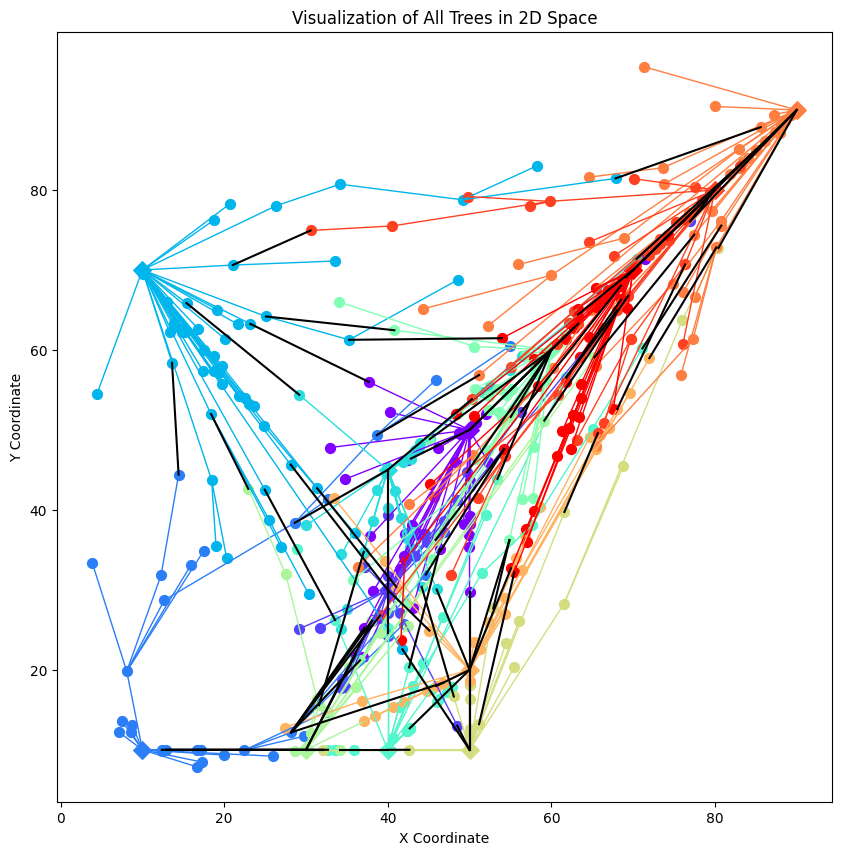

In [11]:
plt.figure(figsize=(10, 10))
solver.plot_all_trees()
solver.plot_connections()

In [73]:
allocation_, cost_ = solver.random_allocate_goals(10000)
print(cost_)

191.4271549879204


## Experiment 1

In [333]:
def plot_obstacles1(ax):
  circle = plt.Circle((20,20),5, color='black')
  rec1 = plt.Rectangle((45,20),2,40, color='black')
  rec2 = plt.Rectangle((40,50),2,15, color='black')
  ax.add_patch(circle)
  ax.add_patch(rec1)
  ax.add_patch(rec2)

def plot1(title):
  fig, ax = plt.subplots()
  fig.set_size_inches(10, 10)
  plot_obstacles1(ax)
  solver1.plot_all_trees(ax)
  solver1.plot_connections(ax)
  solver1.plot_connections_paths(ax)
  ax.set_title(title)
  plt.show()

In [334]:
def is_coords_valid1(x):
  return not (np.linalg.norm(x- np.array([20,20])) < 5
              or (45<x[0]<47 and 20<x[1]<60)
              or (40<x[0]<42 and 50<x[1]<65))

np.random.seed(42)
bounds = np.array([[0,0],[100,100]])
goal_sources = np.array([[10,10], [10,70], [40,45]])
robot_sources = np.array([[50,50], [40, 30]])
steer_step_size = 5
p_task_space=0.3
p_vertex_contraction=0.3
collision_step_size = 0.1
min_drive_speed = 3
max_drive_speed = 5
max_turn_time = 1
collision_distance = 2

solver1 = NewRRTSolver(robot_sources, goal_sources, bounds, p_task_space,
                 steer_step_size, is_coords_valid1, collision_step_size,
                 p_vertex_contraction, min_drive_speed, max_drive_speed,
                 max_turn_time, collision_distance)

Plotting Tree ID: 0, Type: robot
Plotting Tree ID: 1, Type: robot
Plotting Tree ID: 2, Type: goal
Plotting Tree ID: 3, Type: goal
Plotting Tree ID: 4, Type: goal


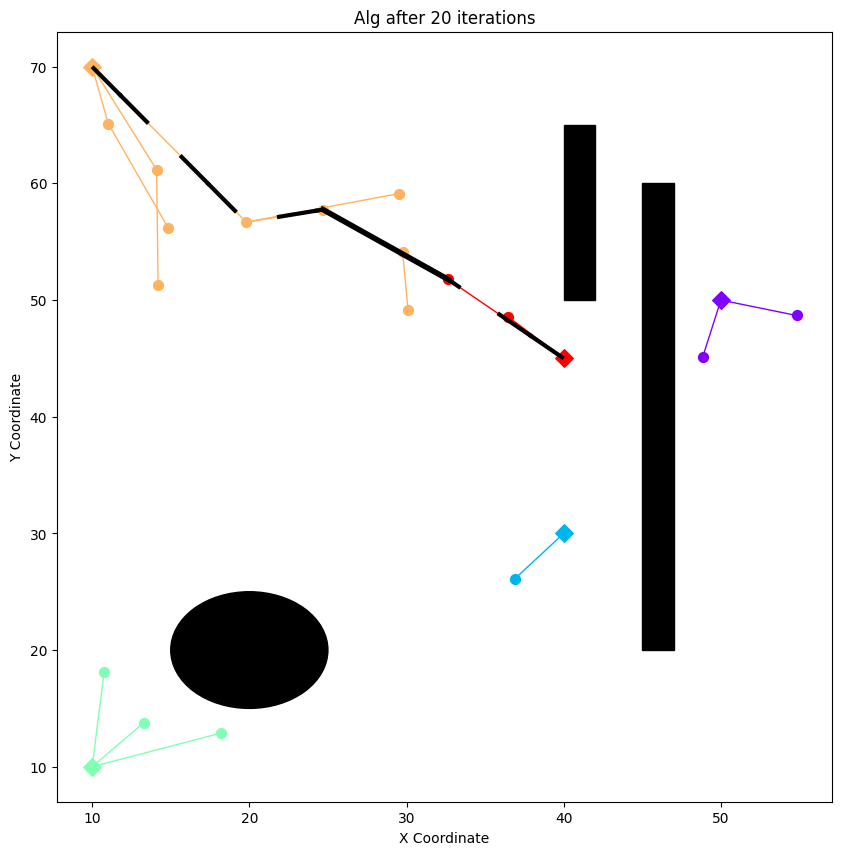

In [335]:
for i in range(20):
  solver1.random_expend_tree()
plot1('Alg after 20 iterations')

Plotting Tree ID: 0, Type: robot
Plotting Tree ID: 1, Type: robot
Plotting Tree ID: 2, Type: goal
Plotting Tree ID: 3, Type: goal
Plotting Tree ID: 4, Type: goal


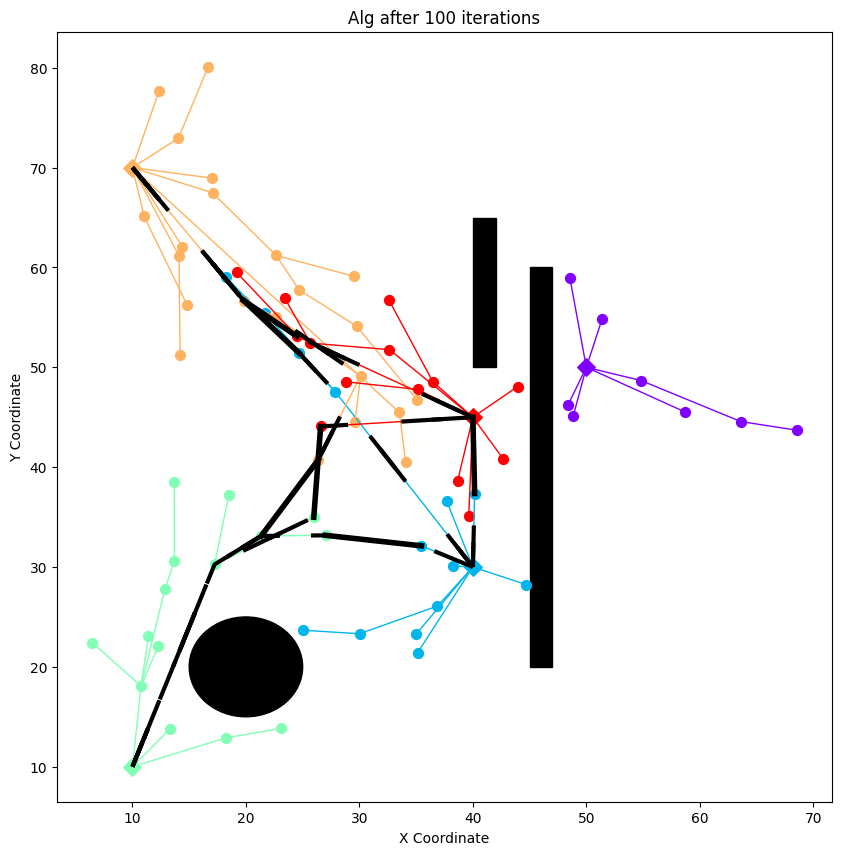

In [336]:
for i in range(80):
  solver1.random_expend_tree()
plot1('Alg after 100 iterations')

Plotting Tree ID: 0, Type: robot
Plotting Tree ID: 1, Type: robot
Plotting Tree ID: 2, Type: goal
Plotting Tree ID: 3, Type: goal
Plotting Tree ID: 4, Type: goal


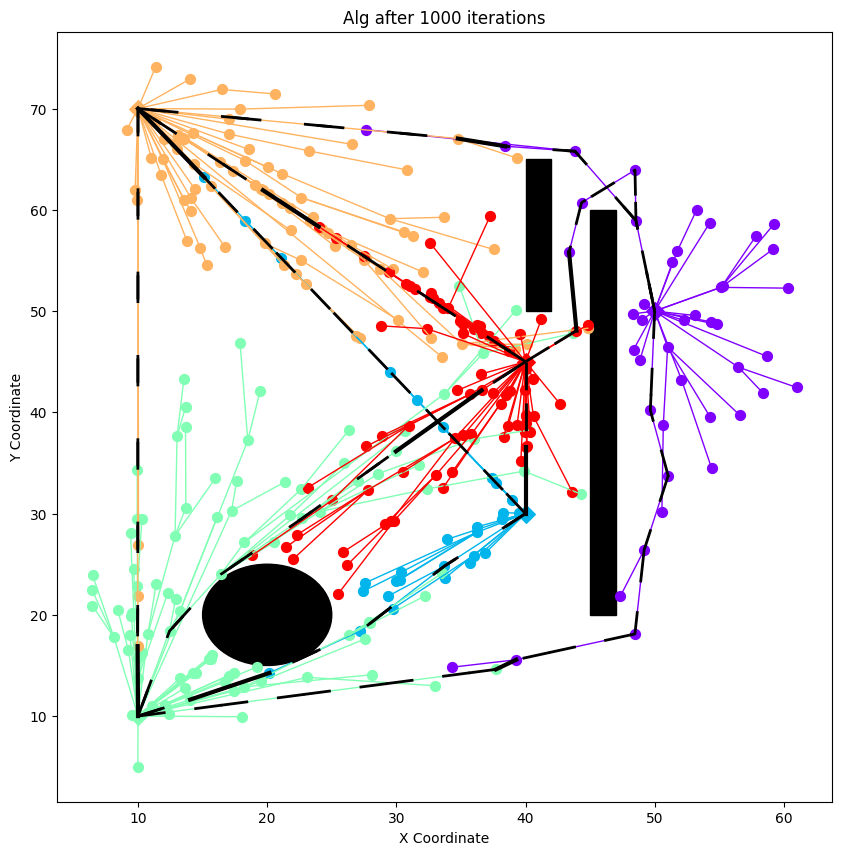

True


In [331]:
for i in range(900):
  solver1.random_expend_tree()
plot1('Alg after 1000 iterations')
print(solver1.are_trees_connected())

Plotting Tree ID: 0, Type: robot
Plotting Tree ID: 1, Type: robot
Plotting Tree ID: 2, Type: goal
Plotting Tree ID: 3, Type: goal
Plotting Tree ID: 4, Type: goal


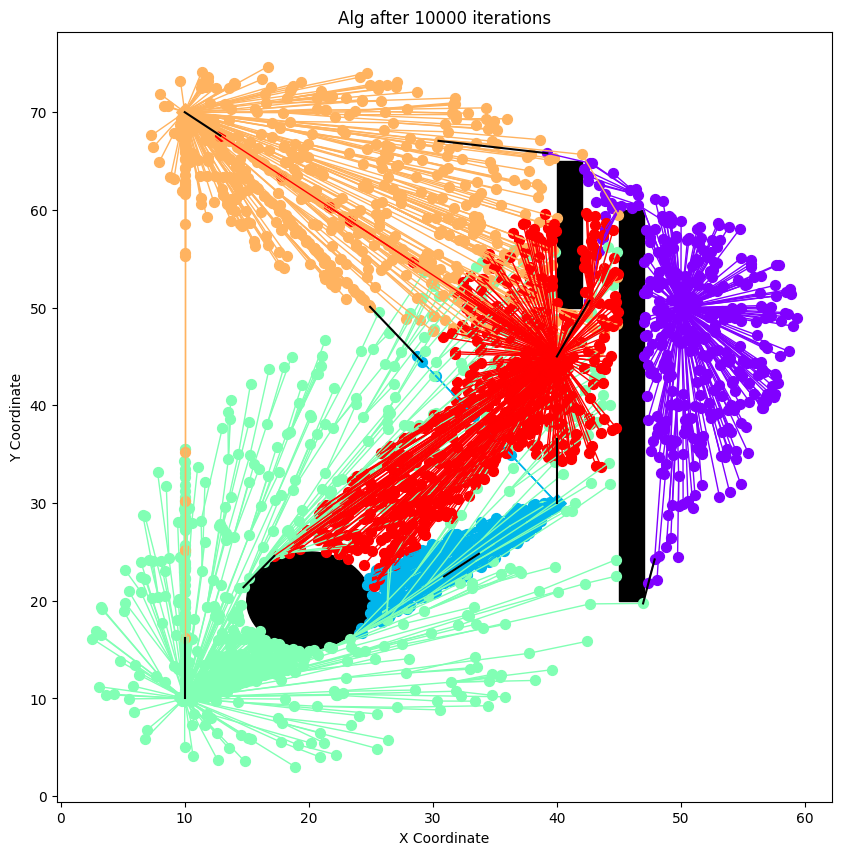

In [205]:
for i in range(9000):
  solver1.random_expend_tree()
plot1('Alg after 10000 iterations')

## Experiment 2

In [253]:
np.random.seed(42)
bounds = np.array([[0,0],[100,100]])
goal_sources2 = np.array([[10,10], [10,70], [40,45]])
robot_sources2 = np.array([[50,50], [40, 30]])
steer_step_size = 5
p_task_space=0.3
p_vertex_contraction=0.3
collision_step_size = 0.1
min_drive_speed = 3
max_drive_speed = 5
max_turn_time = 1
collision_distance = 2

solver2 = NewRRTSolver(robot_sources2, goal_sources2, bounds, p_task_space,
                 steer_step_size, is_coords_valid1, collision_step_size,
                 p_vertex_contraction, min_drive_speed, max_drive_speed,
                 max_turn_time, collision_distance)

In [221]:
static_c_bests = []
for i in range(10000):
  solver2.random_expend_tree()
  static_c_best = solver.get_static_c_best()
  static_c_bests.append(static_c_best)

In [222]:
transposed = {}

for tree_pair in static_c_bests[0]:
  transposed[tree_pair] = []

for static_c_best in static_c_bests:
  for tree_pair in static_c_best:
    transposed[tree_pair].append(static_c_best[tree_pair])

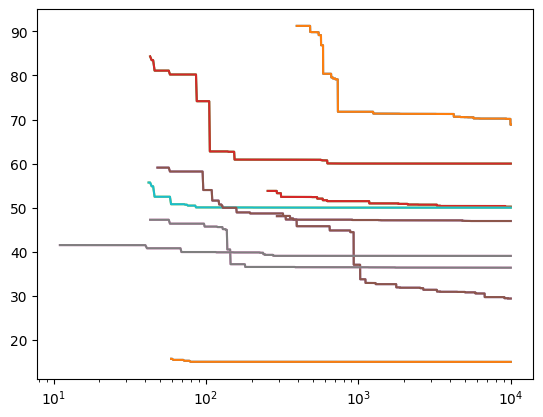

In [223]:
for tree_pair in transposed:
  tree_pair_costs = transposed[tree_pair]
  steps = list(range(1,len(tree_pair_costs)+1))
  plt.plot(steps, tree_pair_costs)

plt.xscale('log')

## Experiment 3

In [254]:
def plot3(title, solvers, colors):
  fig, ax = plt.subplots()
  fig.set_size_inches(10, 10)
  plot_obstacles1(ax)
  for tree_pair in solvers:
    solver = solvers[tree_pair]
    solver.plot_tree(solver.trees[0], colors[tree_pair[0]],ax)
    solver.plot_tree(solver.trees[1], colors[tree_pair[1]],ax)
    solver.plot_connections(ax)
  ax.set_title(title)
  plt.show()

In [255]:
np.random.seed(42)
solvers = {}
for idx1 in range(len(solver2.trees)):
  for idx2 in range(idx1+1, len(solver2.trees)):
    if is_tree_pair_valid(solver2.trees[idx1], solver2.trees[idx2]):
      source1, source2 = solver2.trees[idx1].root.coordinates, solver2.trees[idx2].root.coordinates
      solver = NewRRTSolver([source1,], [source2,], bounds, p_task_space,
                    steer_step_size, is_coords_valid1, collision_step_size,
                    p_vertex_contraction, min_drive_speed, max_drive_speed,
                    max_turn_time, collision_distance)
      solvers[(idx1,idx2)] = solver

In [256]:
counter = 0
tree_pairs = list(solvers.keys())
n_tree_pairs = len(tree_pairs)
for i in range(1000):
  tree_pair = tree_pairs[counter]
  solver = solvers[tree_pair]
  solver.random_expend_tree()
  counter = (counter+1)%n_tree_pairs

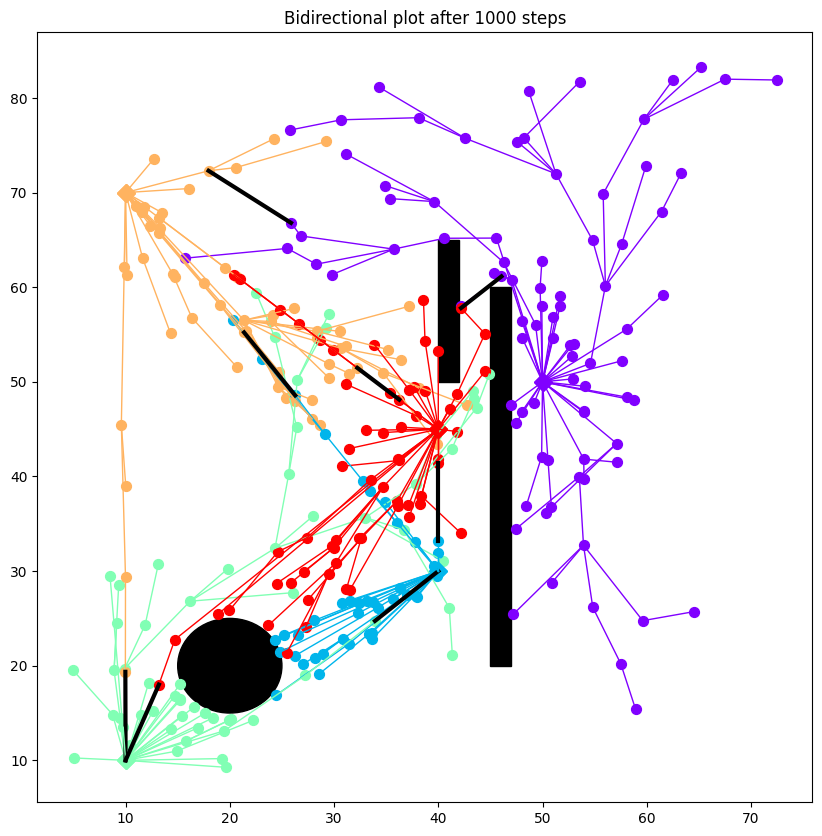

In [257]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(solver2.trees)))
plot3('Bidirectional plot after 1000 steps', solvers, colors)

In [259]:
for solver in solvers.values():
  print(solver.are_trees_connected())

False
True
True
True
True
True
True
True
True


# Experiment 4

# Ellipsoid Sampler testing

In [ ]:
#@title Test ellipsoid sampler
x_start = np.array([0, 0])
x_goal = np.array([100, 50])
c_best = 1.1*np.linalg.norm(x_start-x_goal)
sampler = InformedSampler(x_goal, x_start)
for i in range(1000):
  x = sampler.sample(c_best)
  plt.plot(x[0], x[1], 'bo')

plt.plot(x_start[0], x_start[1], 'ro')
plt.plot(x_goal[0], x_goal[1], 'go')